In [1]:
%pip install pandas
%pip install requests
%pip install python-dotenv
%pip install matplotlib
%pip install seaborn
%pip install statsmodels
%pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import requests
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
load_dotenv()

# Parametros da API FRED
FRED_API_KEY = os.getenv("FRED_API_KEY")
URL_FRED = os.getenv("URL_FRED")

end_point = 'series/observations'

# Ids do payroll, desemprego e índices de mercados
series_ids = ['PAYEMS', 'UNRATE' ,'NASDAQ100', 'SP500']

# Parametros da requisição

def return_params(series_ids):
    return {
        'series_id': series_ids,
        'api_key': FRED_API_KEY,
        'file_type': 'json',
    }

params = []
for param in series_ids:
    params.append(return_params(param))
params


[{'series_id': 'PAYEMS',
  'api_key': '1b2014ec8bef2c11b5361c34ff858288',
  'file_type': 'json'},
 {'series_id': 'UNRATE',
  'api_key': '1b2014ec8bef2c11b5361c34ff858288',
  'file_type': 'json'},
 {'series_id': 'NASDAQ100',
  'api_key': '1b2014ec8bef2c11b5361c34ff858288',
  'file_type': 'json'},
 {'series_id': 'SP500',
  'api_key': '1b2014ec8bef2c11b5361c34ff858288',
  'file_type': 'json'}]

In [4]:
# Lista de respostas da API
responses = []
obs_data = []
for param in params:
    response = requests.get(URL_FRED + end_point, params=param)
    if response.status_code == 200:
        res_data = (response.json())
        obs_data.append(pd.DataFrame(res_data['observations']))
        obs_data[-1]['date'] = pd.to_datetime(obs_data[-1]['date'])
        obs_data[-1].set_index('date', inplace=True)
        obs_data[-1]['value'] = pd.to_numeric(obs_data[-1]['value'], errors='coerce')
    else:
        print(f"Erro na requisição para {param['series_id']}: {response.status_code}")
    responses.append(response)

In [5]:
obs_data[1]

,realtime_start,realtime_end,value
date,,,
1948-01-01,2026-02-11,2026-02-11,3.4
1948-02-01,2026-02-11,2026-02-11,3.8
1948-03-01,2026-02-11,2026-02-11,4.0
1948-04-01,2026-02-11,2026-02-11,3.9
1948-05-01,2026-02-11,2026-02-11,3.5
...,...,...,...
2025-09-01,2026-02-11,2026-02-11,4.4
2025-10-01,2026-02-11,2026-02-11,NaN
2025-11-01,2026-02-11,2026-02-11,4.5


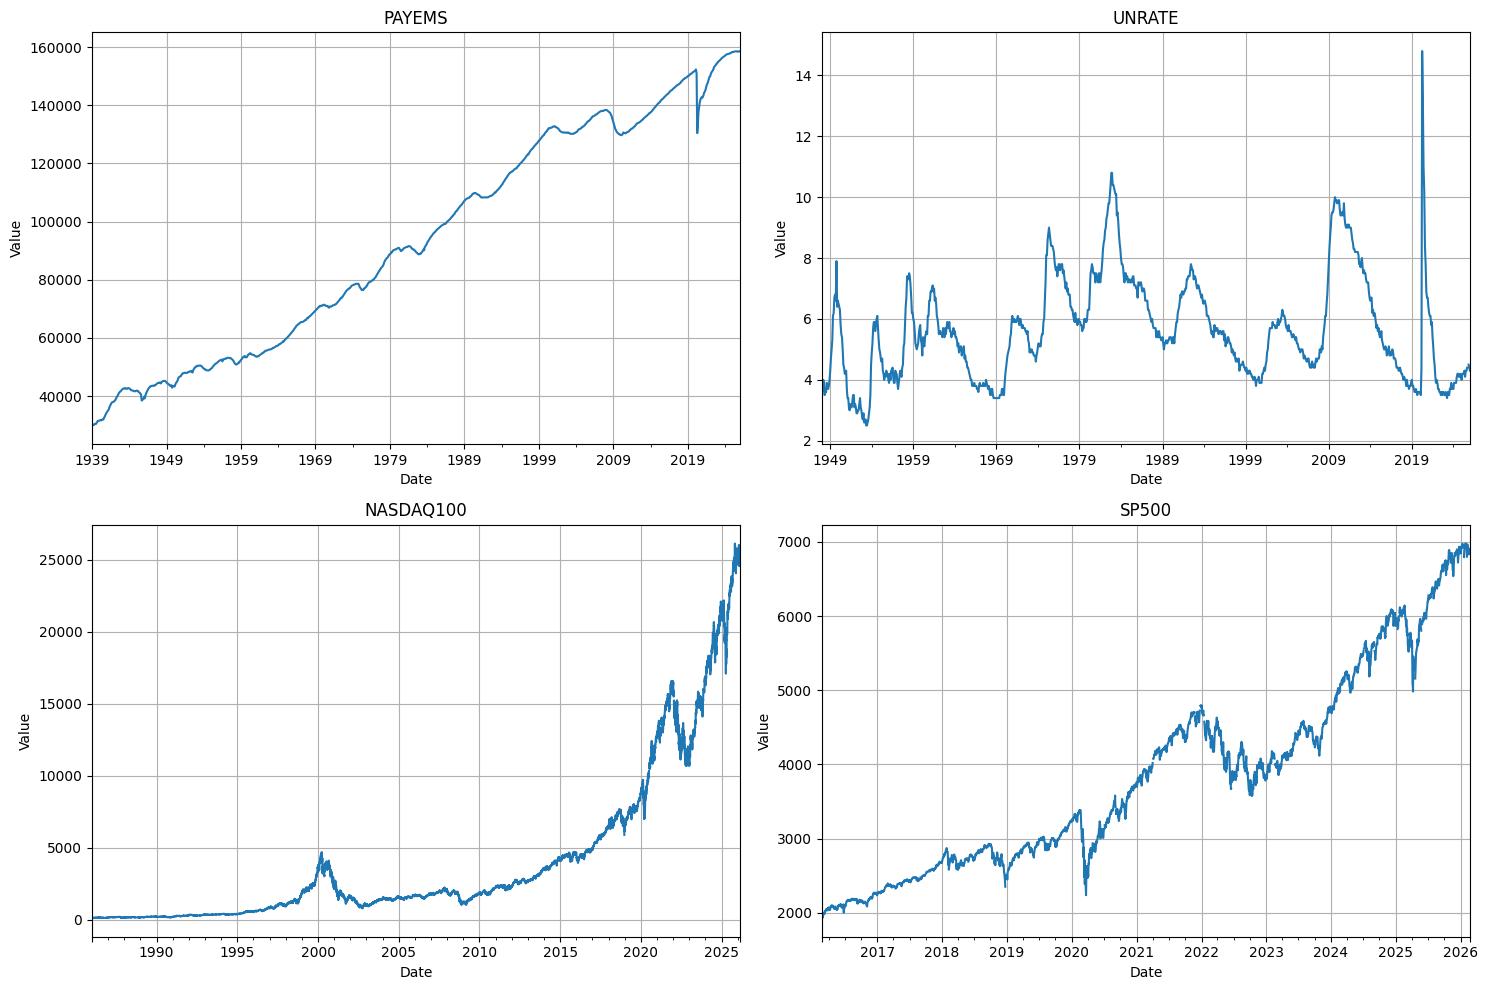

In [6]:
# Visualização dos dados
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(len(series_ids)):
    obs_data[i]['value'].plot(ax=axes[i], title=series_ids[i])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

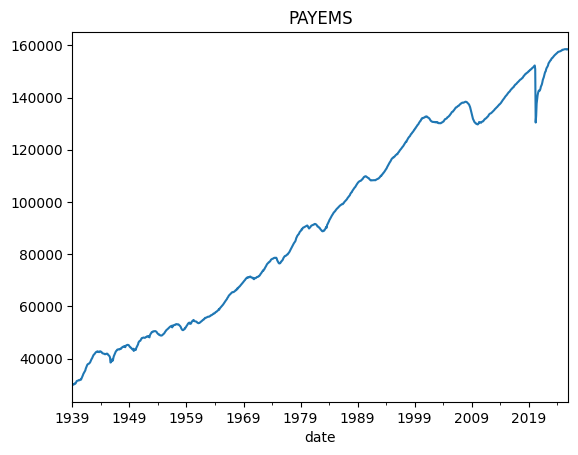

In [7]:
series_name = 'PAYEMS'              
idx = series_ids.index(series_name)  

s = obs_data[idx]['value'].astype(float).dropna()

freq = pd.infer_freq(s.index)
if freq is None:
    print("Frequência não inferida — será usado 'M' (mensal).")
    s = s.resample('M').mean()
else:
    s = s.asfreq(freq)

s.head()
s.plot(title=series_name); plt.show()

In [8]:
# Augmented Dickey-Fuller Test
def adf_test(series):
    res = adfuller(series.dropna())
    print('ADF test:')
    print(f'  stat = {res[0]:.4f}, p-value = {res[1]:.4f}')
    for key, val in res[4].items():
        print(f'    crit {key}: {val:.4f}')

# KPSS Test
def kpss_test(series, regression='c'):
    res = kpss(series.dropna(), regression=regression, nlags='auto')
    print('KPSS test:')
    print(f'  stat = {res[0]:.4f}, p-value = {res[1]:.4f}')
    for key, val in res[3].items():
        print(f'    crit {key}: {val:.4f}')

adf_test(s)
kpss_test(s)

ADF test:
  stat = -0.1394, p-value = 0.9454
    crit 1%: -3.4366
    crit 5%: -2.8643
    crit 10%: -2.5682
KPSS test:
  stat = 5.3466, p-value = 0.0100
    crit 10%: 0.3470
    crit 5%: 0.4630
    crit 2.5%: 0.5740
    crit 1%: 0.7390


C:\Users\Usuario\AppData\Local\Temp\ipykernel_11768\3730146072.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series.dropna(), regression=regression, nlags='auto')


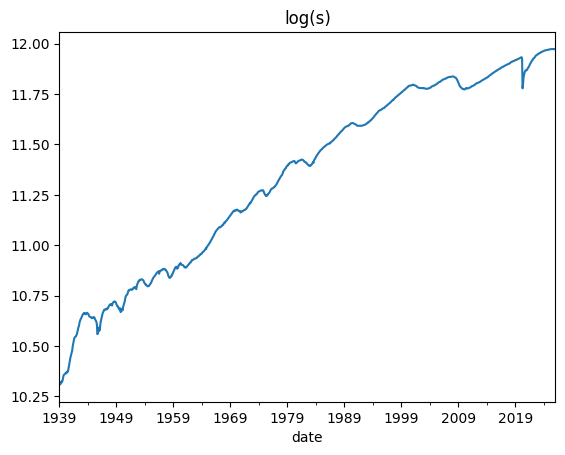

In [9]:
s_log = np.log(s.replace(0, np.nan)).dropna()
s_log.plot(title='log(s)'); plt.show()

ADF test:
  stat = -24.8956, p-value = 0.0000
    crit 1%: -3.4366
    crit 5%: -2.8643
    crit 10%: -2.5682
KPSS test:
  stat = 0.0520, p-value = 0.1000
    crit 10%: 0.3470
    crit 5%: 0.4630
    crit 2.5%: 0.5740
    crit 1%: 0.7390


C:\Users\Usuario\AppData\Local\Temp\ipykernel_11768\3730146072.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(series.dropna(), regression=regression, nlags='auto')


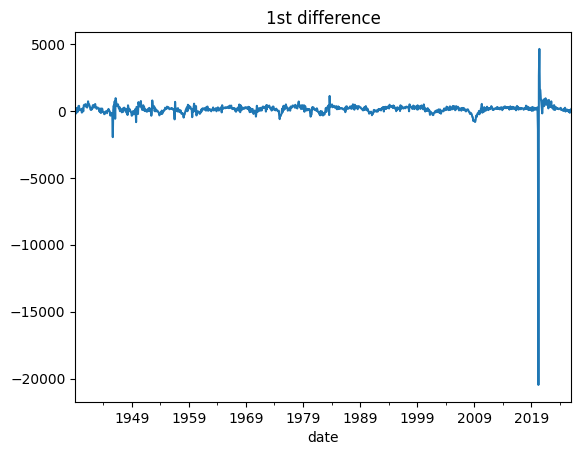

In [10]:
s_diff = s.diff().dropna()
adf_test(s_diff)
kpss_test(s_diff)
s_diff.plot(title='1st difference'); plt.show()

ADF test:
  stat = -7.4931, p-value = 0.0000
    crit 1%: -3.4368
    crit 5%: -2.8644
    crit 10%: -2.5683
KPSS test:
  stat = 0.0567, p-value = 0.1000
    crit 10%: 0.3470
    crit 5%: 0.4630
    crit 2.5%: 0.5740
    crit 1%: 0.7390


C:\Users\Usuario\AppData\Local\Temp\ipykernel_11768\3730146072.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(series.dropna(), regression=regression, nlags='auto')


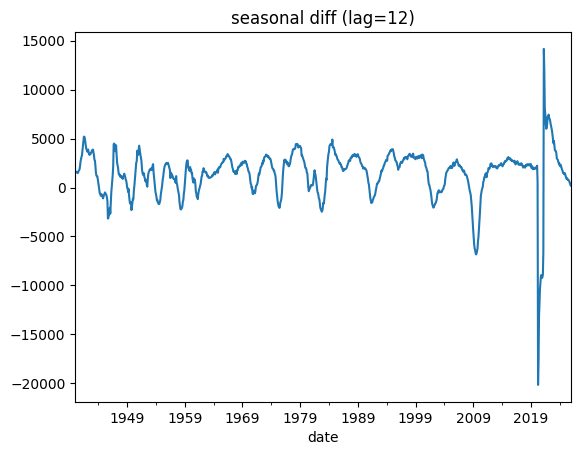

ADF test:
  stat = -11.8722, p-value = 0.0000
    crit 1%: -3.4368
    crit 5%: -2.8644
    crit 10%: -2.5683
KPSS test:
  stat = 0.0067, p-value = 0.1000
    crit 10%: 0.3470
    crit 5%: 0.4630
    crit 2.5%: 0.5740
    crit 1%: 0.7390


C:\Users\Usuario\AppData\Local\Temp\ipykernel_11768\3730146072.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(series.dropna(), regression=regression, nlags='auto')


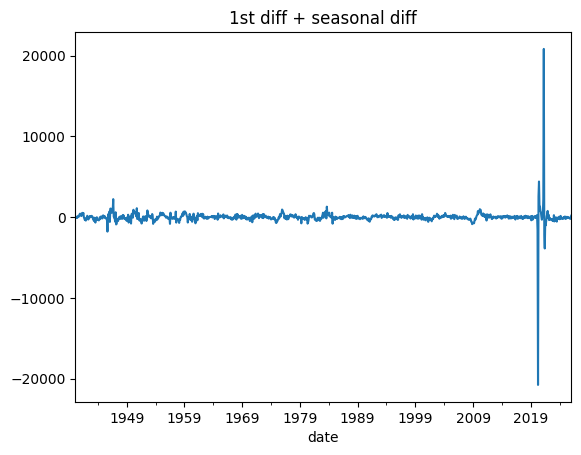

In [11]:
# diferença sazonal (lag 12)
s_seas_diff = s.diff(12).dropna()
adf_test(s_seas_diff)
kpss_test(s_seas_diff)
s_seas_diff.plot(title='seasonal diff (lag=12)'); plt.show()

# diferença regular combinada com sazonal
s_both = s.diff().diff(12).dropna()
adf_test(s_both)
kpss_test(s_both)
s_both.plot(title='1st diff + seasonal diff'); plt.show()

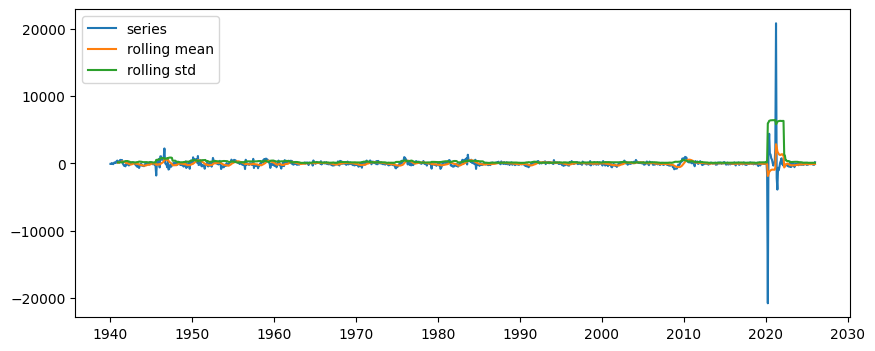

In [12]:
rol_mean = s_both.rolling(window=12).mean()
rol_std  = s_both.rolling(window=12).std()
plt.figure(figsize=(10,4))
plt.plot(s_both, label='series')
plt.plot(rol_mean, label='rolling mean')
plt.plot(rol_std, label='rolling std')
plt.legend(); plt.show()

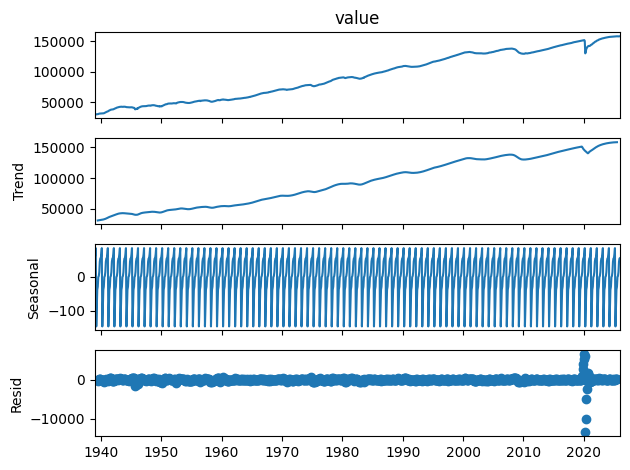

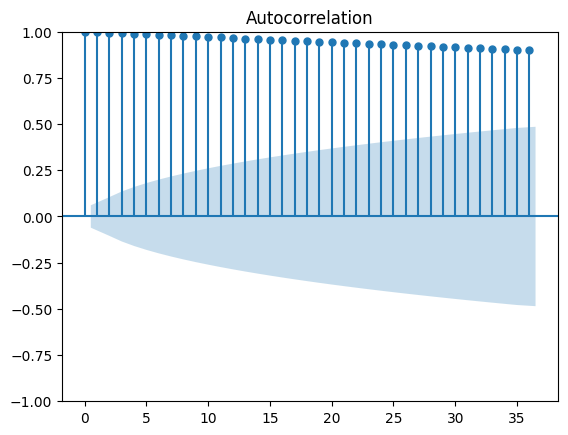

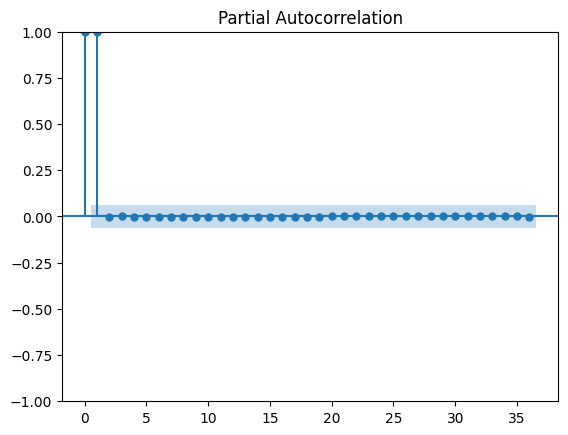

In [13]:
# decompor mensalmente
res = seasonal_decompose(s, model='additive', period=12)
res.plot(); plt.show()

# ACF / PACF para checar lags
plot_acf(s.dropna(), lags=36); plt.show()
plot_pacf(s.dropna(), lags=36, method='ywm'); plt.show()